<a href="https://colab.research.google.com/github/jungeun202/Transformer/blob/main/LUNA__%ED%99%A9%EC%A0%95%EC%9D%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Luna
*   Two nested linear attention functions, pack and unpack attention, allowing linear time and space complexity.

In [1]:
import math
import torch
import torch.nn as nn
from torch import Tensor

In [2]:
import torch.nn.functional as F
import numpy as np
from typing import Optional, Tuple

In [3]:
import os
import copy
import time

from torch.autograd import Variable
from torch.nn.utils import clip_grad_norm_


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Embedding

In [4]:
class PositionalEncoding(nn.Module): # inherits from nn.Module, the base class for all neural network modules in PyTorch
    """
    Positional Encoding proposed in "Attention Is All You Need".
    Since transformer contains no recurrence and no convolution, in order for the model to make
    use of the order of the sequence, we must add some positional information.

    "Attention Is All You Need" use sine and cosine functions of different frequencies:
        PE_(pos, 2i)    =  sin(pos / power(10000, 2i / d_model))
        PE_(pos, 2i+1)  =  cos(pos / power(10000, 2i / d_model))
    each position in the sequence (pos) is encoded differently in each dimension of the embedding
    (either sine or cosine based on whether the dimension is even or odd).
    """
    def __init__(self, d_model: int = 80, max_length: int = 5000) -> None:
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_length, d_model, requires_grad=False) # initialized to store the positional encodings | no need to compute gradients
        # generate a 1d tensor containing values 0 to max_length - 1 in floating-point format | adds an extra dimension to the tensor ; [max_length] -> [max_length, 1]
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1).float()
        # creates a sequence of even numbers from 0 to less than max_length | a negative scaling factor and normalize by dividing d_model | exponentiates the scaled indices
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term) # for each even-indexed dimension
        pe[:, 1::2] = torch.cos(position * div_term) # for each odd-indexed dimension
        # position tensor shape is [max_length, 1] and div_term has shape [d_model/2] ; scaled by each div_term
        # pe has a shape of [max_length, d_model]
        pe = pe.unsqueeze(0) # add an extra dimension ; [max_length, d_model, 1]
        self.register_buffer('pe', pe) # save as a buffer; easily available during model training and inference without recomputation

    def forward(self, length: int) -> Tensor:
        # print(f"Positional Encoding Output Shape: {self.pe[:, :length].shape}")
        # Positional Encoding Output Shape: torch.Size([1, 2, 128])
        # Positional Encoding Output Shape: torch.Size([1, 5, 128])
        return self.pe[:, :length]

## Encoding

In [5]:
class LunaTransformerEncoderLayer(nn.Module):
    def __init__(
            self,
            d_model: int = 512,
            num_attention_heads: int = 8,
            d_ff: int = 2048,
            dropout_p: float = 0.3,
    ) -> None:
        super(LunaTransformerEncoderLayer, self).__init__()
        self.luna_attention = LinearUnifiedNestedAttention(d_model, num_attention_heads)
        self.feed_forward = PositionwiseFeedForwardNetwork(d_model, d_ff, dropout_p)
        self.packed_context_layer_norm = nn.LayerNorm(d_model)
        self.unpacked_context_layer_norm = nn.LayerNorm(d_model)
        self.unpacked_context_layer_norm = nn.LayerNorm(d_model)
        self.feed_forward_layer_norm = nn.LayerNorm(d_model)

    def forward(
            self,
            inputs: torch.FloatTensor,
            p: torch.FloatTensor,
            attention_padding_mask: torch.FloatTensor = None,
    ):
        unpacked_context, packed_context = self.luna_attention(
            query=inputs,
            key=inputs,
            value=inputs,
            p=p,
            attention_padding_mask=attention_padding_mask,
        )

        packed_context = self.packed_context_layer_norm(packed_context + p) # extra input p | pack attention costs O(lm)
        unpacked_context = self.unpacked_context_layer_norm(unpacked_context + inputs) # unpack the original query

        outputs = self.feed_forward(unpacked_context)
        outputs = self.feed_forward_layer_norm(outputs + unpacked_context)

        return outputs, packed_context

## Attention

In [6]:
class DotProductAttention(nn.Module):
    r"""
    Scaled Dot-Product Attention proposed in "Attention Is All You Need"
    Compute the dot products of the query with all keys, divide each by sqrt(dim),
    and apply a softmax function to obtain the weights on the values

    Args: dim, mask
        dim (int): dimension of attention
        mask (torch.Tensor): tensor containing indices to be masked

    Inputs: query, key, value, mask
        - **query** (batch, q_len, d_model): tensor containing projection vector for decoders.
        - **key** (batch, k_len, d_model): tensor containing projection vector for encoders.
        - **value** (batch, v_len, d_model): tensor containing features of the encoded input sequence.
        - **mask** (-): tensor containing indices to be masked

    Returns: context, attn
        - **context**: tensor containing the context vector from attention mechanism.
        - **attn**: tensor containing the attention (alignment) from the encoders outputs.
    """
    def __init__(self, dim: int, scale: bool = True) -> None:
        super(DotProductAttention, self).__init__()
        if scale:
            self.sqrt_dim = np.sqrt(dim)
        else:
            self.sqrt_dim = 1

    def forward(
            self,
            query: torch.FloatTensor,
            key: torch.FloatTensor,
            value: torch.FloatTensor,
            mask: Optional[torch.FloatTensor] = None,
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        score = torch.matmul(query, key.transpose(2, 3)) / self.sqrt_dim

        if mask is not None:
            score.masked_fill_(mask, -1e4)

        attn = F.softmax(score, -1)

        if len(query.size()) == 3:
            context = torch.bmm(attn, value)
        else:
            context = torch.matmul(attn, value)

        return context, attn


class MultiHeadAttention(nn.Module):
    r"""
    Multi-Head Attention proposed in "Attention Is All You Need"
    Instead of performing a single attention function with d_model-dimensional keys, values, and queries,
    project the queries, keys and values h times with different, learned linear projections to d_head dimensions.
    These are concatenated and once again projected, resulting in the final values.
    Multi-head attention allows the model to jointly attend to information from different representation
    subspaces at different positions.

    MultiHead(Q, K, V) = Concat(head_1, ..., head_h) · W_o
        where head_i = Attention(Q · W_q, K · W_k, V · W_v)

    Args:
        dim (int): The dimension of model (default: 512)
        num_attention_heads (int): The number of attention heads. (default: 8)

    Inputs: query, key, value, mask
        - **query** (batch, q_len, d_model): tensor containing projection vector for decoders.
        - **key** (batch, k_len, d_model): tensor containing projection vector for encoders.
        - **value** (batch, v_len, d_model): tensor containing features of the encoded input sequence.
        - **mask** (-): tensor containing indices to be masked

    Returns: output, attn
        - **output** (batch, output_len, dimensions): tensor containing the attended output features.
        - **attn** (batch * num_attention_heads, v_len): tensor containing the attention (alignment) from the encoders outputs.
    """
    def __init__(self, dim: int = 512, num_attention_heads: int = 8) -> None:
        super(MultiHeadAttention, self).__init__()

        assert dim % num_attention_heads == 0, "hidden_dim % num_attention_heads should be zero."

        self.d_head = int(dim / num_attention_heads)
        self.num_attention_heads = num_attention_heads
        self.query_proj = nn.Linear(dim, self.d_head * num_attention_heads)
        self.key_proj = nn.Linear(dim, self.d_head * num_attention_heads)
        self.value_proj = nn.Linear(dim, self.d_head * num_attention_heads)
        self.scaled_dot_attn = DotProductAttention(dim, scale=True)

    def forward(
            self,
            query: torch.FloatTensor,
            key: torch.FloatTensor,
            value: torch.FloatTensor,
            mask: Optional[torch.FloatTensor] = None,
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        batch_size = value.size(0)

        query = self.query_proj(query).view(batch_size, -1, self.num_attention_heads, self.d_head).transpose(1, 2)
        key = self.key_proj(key).view(batch_size, -1, self.num_attention_heads, self.d_head).transpose(1, 2)
        value = self.value_proj(value).view(batch_size, -1, self.num_attention_heads, self.d_head).transpose(1, 2)
        # print(f"MultiHead Attention Split Shapes: query={query.shape}, key={key.shape}, value={value.shape}")
        # query=torch.Size([20, 8, 5, 16]), key=torch.Size([20, 8, 2, 16]), value=torch.Size([20, 8, 2, 16])
        # query=torch.Size([20, 8, 2, 16]), key=torch.Size([20, 8, 5, 16]), value=torch.Size([20, 8, 5, 16])

        if mask is not None:
            mask = mask.unsqueeze(1).repeat(1, self.num_attention_heads, 1, 1)

        context, attn = self.scaled_dot_attn(query, key, value, mask)
        # print(f"Attention Output Shape: context={context.shape}, attn={attn.shape}")
        # context=torch.Size([20, 8, 5, 16]), attn=torch.Size([20, 8, 5, 2])
        # context=torch.Size([20, 8, 2, 16]), attn=torch.Size([20, 8, 2, 5])

        context = context.transpose(1, 2).reshape(batch_size, -1, self.num_attention_heads * self.d_head)

        return context, attn


class LinearUnifiedNestedAttention(nn.Module): # LUNA has two nested attention operations with an extra input p
    def __init__(self, dim, num_attention_heads: int = 8) -> None:
        super(LinearUnifiedNestedAttention, self).__init__()
        self.pack_attention = MultiHeadAttention(dim, num_attention_heads)
        self.unpack_attention = MultiHeadAttention(dim, num_attention_heads)

    def forward(
            self,
            query: torch.FloatTensor,
            key: torch.FloatTensor,
            value: torch.FloatTensor,
            p: torch.FloatTensor,
            attention_padding_mask: torch.BoolTensor = None,
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        packed_context, _ = self.pack_attention(p, key, value, attention_padding_mask) # Pack attention with an extra input p and context sequence
        unpacked_context, _ = self.unpack_attention(query, packed_context, packed_context) # Unpack attention with a query and packed context
        # print(f"LUNA Attention Shapes: key={key}, value = {value}, query={query}")
        # packed_context=torch.Size([20, 5, 128]), unpacked_context=torch.Size([20, 2, 128])
        return unpacked_context, packed_context

## Feedforward

In [7]:
class PositionwiseFeedForwardNetwork(nn.Module):
    """
    Position-wise Feedforward Networks proposed in "Attention Is All You Need".
    Fully connected feed-forward network, which is applied to each position separately and identically.
    This consists of two linear transformations with a ReLU activation in between.
    Another way of describing this is as two convolutions with kernel size 1.
    """
    def __init__(self, d_model: int = 512, d_ff: int = 2048, dropout_p: float = 0.3) -> None:
        super(PositionwiseFeedForwardNetwork, self).__init__()
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.Dropout(dropout_p),
            nn.ReLU(),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout_p),
        )

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        output = self.feed_forward(inputs)
        # print(f"Feed Forward Network Input/Output Shapes: input={inputs.shape}, output={output.shape}")
        # Feed Forward Network Input/Output Shapes: input=torch.Size([20, 2, 128]), output=torch.Size([20, 2, 128])
        return output

## Model

In [8]:
class LunaTransformerEncoder(nn.Module):
    """
    Transformer encoder architecture applied Linear Unified Nested Attention (Luna).
    Luna was proposed in the paper "Luna: Linear Unified Nested Attention" (https://arxiv.org/abs/2106.01540.pdf)
    """
    def __init__(
            self,
            vocab_size: int,
            d_model: int,
            num_layers: int = 6,
            num_attention_heads: int = 8,
            d_ff: int = 2048,
            dropout_p: float = 0.1,
            project_embedding_length: int = 5,
            max_length: int = 1024,
    ):
        super(LunaTransformerEncoder, self).__init__()
        self.d_model = d_model
        self.projected_embedding_length = project_embedding_length

        self.projected_embeddings = nn.Parameter(torch.Tensor(project_embedding_length, self.d_model))
        self.projected_positions = PositionalEncoding(self.d_model, project_embedding_length)
        nn.init.normal_(self.projected_embeddings, mean=0.0, std=self.d_model ** -0.5)

        self.input_embedding = nn.Embedding(vocab_size, d_model) # vocab_size: 745 , d_model: 4
        self.dropout = nn.Dropout(p=dropout_p)
        self.input_positions = PositionalEncoding(d_model, max_length)

        self.input_norm = nn.LayerNorm(d_model)
        self.embed_scale = math.sqrt(self.d_model)
        self.layers = nn.ModuleList([
            LunaTransformerEncoderLayer(
                d_model=d_model,
                num_attention_heads=num_attention_heads,
                d_ff=d_ff,
                dropout_p=dropout_p,
            ) for _ in range(num_layers)
        ])

        self.projection_head = nn.Linear(d_model, vocab_size)

    def forward(self, inputs: torch.Tensor, input_lengths: torch.Tensor):
        batch_size, seq_length = inputs.size()  # batch_size: 20 , seq_length
        attention_padding_mask = get_attn_pad_mask(inputs, input_lengths, self.projected_embedding_length)

        embedded = self.input_embedding(inputs)
        embedded *= self.embed_scale
        # print(f"Input Embedding Shape: {embedded.shape}") # Input Embedding Shape: torch.Size([20, 2, 128])
        projected_embedded = self.projected_embeddings * self.embed_scale

        embedded += self.input_positions(embedded.size(1))
        projected_embedded += self.projected_positions(self.projected_embedding_length).squeeze(0)

        seq_length, dim = projected_embedded.size()
        projected_embedded = projected_embedded.unsqueeze(0).expand(batch_size, seq_length, dim)

        outputs = self.dropout(embedded)
        p = self.dropout(projected_embedded)

        for layer in self.layers:
            outputs, p = layer(outputs, p, attention_padding_mask)
            # print(f"After Layer Output Shape: {outputs.shape}, Projected Embedding Shape: {p.shape}")
            # After Layer Output Shape: torch.Size([20, 2, 128]), Projected Embedding Shape: torch.Size([20, 5, 128])


        outputs = self.input_norm(outputs)
        outputs = self.projection_head(outputs)
        # print(f"Final Output Shape: {outputs.shape}")
        # Final Output Shape: torch.Size([20, 2, 745])

        return outputs


## Mask

In [9]:
def get_attn_pad_mask(inputs, input_lengths, expand_length):
    """ mask position is set to 1 """

    def get_transformer_non_pad_mask(inputs: Tensor, input_lengths: Tensor) -> Tensor:
        """ Padding position is set to 0, either use input_lengths or pad_id """
        batch_size = inputs.size(0)

        if len(inputs.size()) == 2:
            non_pad_mask = inputs.new_ones(inputs.size())  # B x T
        elif len(inputs.size()) == 3:
            non_pad_mask = inputs.new_ones(inputs.size()[:-1])  # B x T
        else:
            raise ValueError(f"Unsupported input shape {inputs.size()}")


        for i in range(batch_size):

            non_pad_mask[i, int(input_lengths[i]):] = 0

        return non_pad_mask

    non_pad_mask = get_transformer_non_pad_mask(inputs, input_lengths)
    pad_mask = non_pad_mask.lt(1)
    attn_pad_mask = pad_mask.unsqueeze(1).expand(-1, expand_length, -1)
    return attn_pad_mask


def get_attn_subsequent_mask(seq):
    assert seq.dim() == 2
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1)

    if seq.is_cuda:
        subsequent_mask = subsequent_mask.cuda()

    return subsequent_mask

## Dataset


In [15]:
class Dictionary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __len__(self):
        return len(self.word2idx)


class Corpus(object):
    def __init__(self):
        self.dictionary = Dictionary() # to hold the mapping of words to indices

    def get_data(self, path, batch_size=20):
        # Add words to the dictionary
        with open(path, 'r') as f:
            tokens = 0
            # for line in f:
            for i, line in enumerate(f):
                if i == 200:
                  break
                words = line.split() + ['<eos>']
                tokens += len(words)
                for word in words:
                    self.dictionary.add_word(word)
        # convert all words into their respective indices
        # Tokenize the file content
        ids = torch.LongTensor(tokens)
        token = 0
        with open(path, 'r') as f:
            # for line in f:
            for i, line in enumerate(f):
              if i == 200:
                break
              words = line.split() + ['<eos>']
              for word in words:
                  ids[token] = self.dictionary.word2idx[word]
                  token += 1

        # reshape the tensor into batches
        num_batches = ids.size(0) // batch_size # ids.size(0): size of the tensor along its first dimension, total number of tokens | get the num of full batches
        # many neural network architectures require all input data in a batch to have the same size or shape.
        ids = ids[:num_batches*batch_size] # slice to effectectively disregard the remainder
        return ids.view(batch_size, -1) # reshaping to have batch_size rows and enough columns for all tokens in each batch evenly

## hyper parameters & training & evaluation

In [11]:
import matplotlib.pyplot as plt

vocab size:  1226
num batches:  224
test num_batches:  213
Sequence Length: 1, Avg Loss: 7.128503279175077, Time: 17.992810487747192
vocab size:  1226
num batches:  112
test num_batches:  106
Sequence Length: 2, Avg Loss: 7.132958567142486, Time: 9.042753458023071
vocab size:  1226
num batches:  56
test num_batches:  53
Sequence Length: 4, Avg Loss: 7.094519422735487, Time: 4.539479970932007
vocab size:  1226
num batches:  28
test num_batches:  26
Sequence Length: 8, Avg Loss: 6.9815724645342145, Time: 2.578298568725586
vocab size:  1226
num batches:  14
test num_batches:  13
Sequence Length: 16, Avg Loss: 6.764705555779593, Time: 1.6979053020477295
vocab size:  1226
num batches:  8
test num_batches:  8
Sequence Length: 25, Avg Loss: 7.296712672710418, Time: 1.8477725982666016
vocab size:  1226
num batches:  6
test num_batches:  5
Sequence Length: 36, Avg Loss: 7.30134375890096, Time: 1.8710179328918457
vocab size:  1226
num batches:  4
test num_batches:  4
Sequence Length: 49, Avg Los

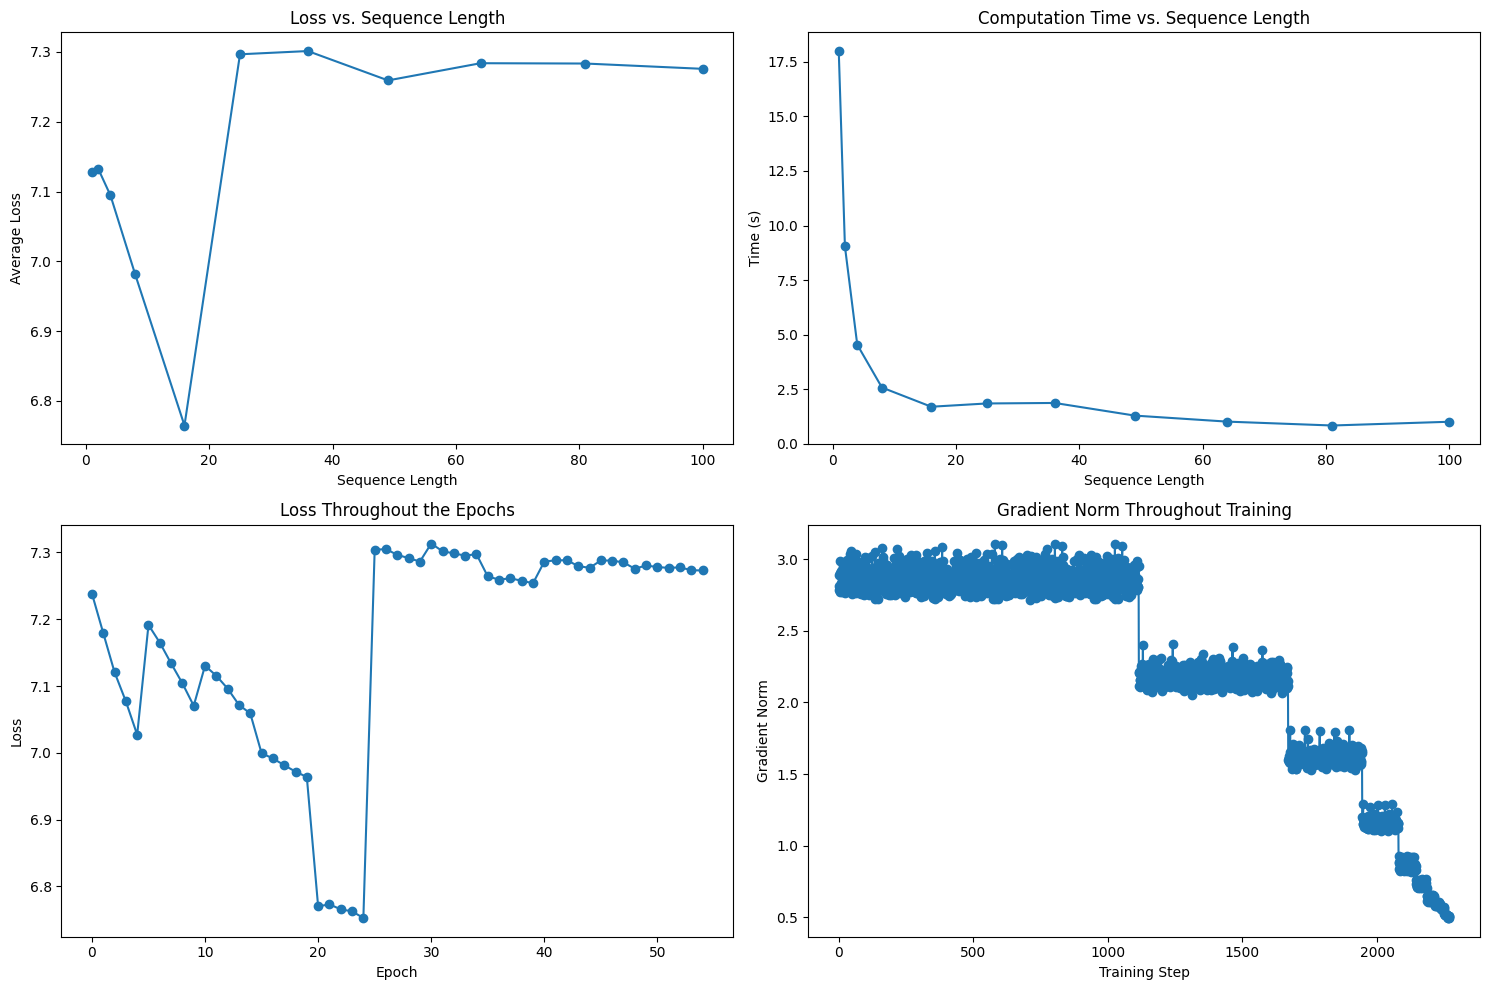

In [22]:
# Hyper-parameters

dim = 128
depth = 1
num_epochs = 5
batch_size = 20 # number of training samples used to compute the gradient in each iteration of the training process.
max_seq_len = 15
learning_rate = 1e-5
head_num = 8
# sequence_lengths = [1, 2, 4, 8, 16]
sequence_lengths = [1, 2, 4, 8, 16, 25,36, 49, 64, 81, 100]  # sequence lengths to test

losses = []
times = []
epoch_losses = []
gradient_norms = []

for max_seq_len in sequence_lengths:
    corpus = Corpus()
    ids = corpus.get_data('/content/drive/MyDrive/train.txt', batch_size)
    vocab_size = len(corpus.dictionary)
    num_batches = ids.size(1) // max_seq_len

    test_corpus = Corpus()
    test_ids = test_corpus.get_data('/content/drive/MyDrive/test.txt', batch_size)
    test_vocab_size = len(test_corpus.dictionary)
    test_num_batches = test_ids.size(1) // max_seq_len

    print("vocab size: ", vocab_size)

    # Device configuration
    model = LunaTransformerEncoder(vocab_size, dim, depth, head_num, max_seq_len, dropout_p=0.1).to(device)

    criterion = nn.CrossEntropyLoss()  # loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    print("num batches: ", num_batches)
    print("test num_batches: ", test_num_batches)
    # Train the model
    start_time = time.time()
    total_loss = 0

    for epoch in range(num_epochs):
        epoch_loss = 0
        for i in range(0, ids.size(1) - max_seq_len, max_seq_len):
          # Get mini-batches
            inputs = ids[:, i:i+max_seq_len].to(device)
            targets = ids[:, (i+1):(i+1)+max_seq_len].to(device)

            # Forward pass
            # Starting each batch, we detach the hidden state from how it was previously produced.
            # If we didn't, the model would try backpropagating all the way to start of the dataset.

            input_lengths = (torch.ones(batch_size) * max_seq_len).to(torch.int32)  # a tensor of the same length for each sequence
            outputs = model(inputs, input_lengths) # process LunaTransformerEncoder's forward method
            output_flat = outputs.view(-1, vocab_size) # reshaped

            # Backward pass
            loss = criterion(output_flat, targets.reshape(-1))

            model.zero_grad()
            loss.backward()

            total_norm = 0
            for param in model.parameters():
                if param.grad is not None:
                    param_norm = param.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** 0.5
            gradient_norms.append(total_norm)

            clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()

            total_loss += loss.item()
            epoch_loss += loss.item()

        epoch_losses.append(epoch_loss / num_batches)

    elapsed_time = time.time() - start_time
    avg_loss = total_loss / (num_batches * num_epochs)
    losses.append(avg_loss)
    times.append(elapsed_time)
    print(f"Sequence Length: {max_seq_len}, Avg Loss: {avg_loss}, Time: {elapsed_time}")

# Plotting
plt.figure(figsize=(15, 10))

# Plot Loss vs. Sequence Length
plt.subplot(2, 2, 1)
plt.plot(sequence_lengths, losses, marker='o')
plt.xlabel('Sequence Length')
plt.ylabel('Average Loss')
plt.title('Loss vs. Sequence Length')

# Plot Computation Time vs. Sequence Length
plt.subplot(2, 2, 2)
plt.plot(sequence_lengths, times, marker='o')
plt.xlabel('Sequence Length')
plt.ylabel('Time (s)')
plt.title('Computation Time vs. Sequence Length')

# Plot Loss Throughout the Epochs
plt.subplot(2, 2, 3)
plt.plot(epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Throughout the Epochs')

# Plot Gradient Norm Throughout Training
plt.subplot(2, 2, 4)
plt.plot(gradient_norms, marker='o')
plt.xlabel('Training Step')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norm Throughout Training')

plt.tight_layout()
plt.show()

* Longer sequence length leads to a larger loss.<br>
    * A bigger input requires the model to learn more attributes, thus increasing the computational complexity.<br>
* Loss function throughout epoch has general decreasing trend but it fluctuates and there are spikes. <br>
* Gradient<br>
    * Becomes large during training cause the model's weights to update in an unstable manner <br>
    * Gradients can explode (grow exponentially) or vanish (shrink exponentially) <br>
* Spikes and large fluctuations in the gradient norm.<br>
    * Exploding gradients.<br>
    * 1. Experimenting with the batch size : 20 -> 32 ; not a significant improvement.<br>
    * 2. Experimenting with the learning rate : 0.002 -> 1e−5 or 2e-5 ; The gradient norm still fluctuates, but the range of these fluctuations has decreased in both gradient norm and loss over epoch graphs.
    * With a batch size of 20 and a learning rate of 1e-5, the gradient norm has converged after a step-wise stabilized decrease. There is a spike in the loss function around epoch 25.  